In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
# from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from scipy.sparse import issparse
from sklearn.inspection import permutation_importance
from scipy.sparse import hstack, csr_matrix

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.options.display.max_colwidth = 1000

[nltk_data] Downloading package punkt to /Users/tudor/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/tudor/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/tudor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [117]:
df = pd.read_csv('TruthSeeker.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
# print("Describe: ", df.describe())
#original tweet features
original_tweet_features = df.iloc[:, 1:4].copy() #de la 1 la 4 cu 2 in 2: gen [statement, BinaryNumTarget, tweet] va lua doar [statement si tweet]
# original_tweet_feature = df["tweet"].copy()

# handcrafted features
meta_data_features = df.iloc[:, 4:22].copy()
text_features = df.iloc[:, 22:46].copy()
lexical_features = df.iloc[:, 46:].copy()
# target output feature
target = df["majority_target"].astype(int).copy()


In [118]:
meta_data_features.drop(columns=["BotScoreBinary", "following", "retweets", "embeddings"], inplace=True) # drop the binary column because it is retaining the same information as the BotScore column
# , giving the fact that the values of the BotScore are represented as percentages
text_features.drop(columns=["Word count", "Max word length", "Min word length", "Average word length"], inplace=True)

In [119]:
def filter_zero_sparse_columns(df: pd.DataFrame, threshold: float = 70.0) -> pd.DataFrame:
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    cols_to_drop = []
    print("="*80)
    for col in numerical_cols:
        total_count = len(df[col])
        zero_count = (df[col]==0).sum()
        zero_percentage = (zero_count / total_count) * 100
        
        if zero_percentage > threshold:
            cols_to_drop.append(col)
            print(f"  DROPPED: '{col}' ({zero_percentage:.2f}% zeros > {threshold}%)")
    if cols_to_drop:
        df_filtered = df.drop(columns=cols_to_drop)
    else:
        df_filtered = df.copy()
    return df_filtered

In [120]:
meta_data_features = filter_zero_sparse_columns(meta_data_features, threshold=70.0)
text_features = filter_zero_sparse_columns(text_features, threshold=70.0)
lexical_features = filter_zero_sparse_columns(lexical_features, threshold=70.0)

print("Meta Data Columns:", meta_data_features.columns.tolist())
print("Text Features Columns:", text_features.columns.tolist())
print("Lexical Features Columns:", lexical_features.columns.tolist())


  DROPPED: 'quotes' (95.71% zeros > 70.0%)
  DROPPED: 'hashtags' (92.97% zeros > 70.0%)
  DROPPED: 'NORP_percentage' (80.36% zeros > 70.0%)
  DROPPED: 'MONEY_percentage' (90.49% zeros > 70.0%)
  DROPPED: 'DATE_percentage' (72.26% zeros > 70.0%)
  DROPPED: 'CARDINAL_percentage' (74.76% zeros > 70.0%)
  DROPPED: 'PERCENT_percentage' (91.39% zeros > 70.0%)
  DROPPED: 'ORDINAL_percentage' (95.74% zeros > 70.0%)
  DROPPED: 'FAC_percentage' (98.84% zeros > 70.0%)
  DROPPED: 'LAW_percentage' (98.39% zeros > 70.0%)
  DROPPED: 'PRODUCT_percentage' (97.60% zeros > 70.0%)
  DROPPED: 'EVENT_percentage' (99.02% zeros > 70.0%)
  DROPPED: 'TIME_percentage' (98.03% zeros > 70.0%)
  DROPPED: 'LOC_percentage' (97.20% zeros > 70.0%)
  DROPPED: 'WORK_OF_ART_percentage' (97.49% zeros > 70.0%)
  DROPPED: 'QUANTITY_percentage' (99.15% zeros > 70.0%)
  DROPPED: 'LANGUAGE_percentage' (99.65% zeros > 70.0%)
  DROPPED: 'determiners' (87.68% zeros > 70.0%)
  DROPPED: 'exclamation' (86.41% zeros > 70.0%)
  DROPPED

In [121]:
stop_words = set(stopwords.words('english'))    

def clean_text(text): 
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Remove URLs
    text = re.sub(r'@\w+', '', text)     #  mentions (@username)
    text = re.sub(r'#\w+', '', text)     # Remove hashtags (#hashtag)
    text = re.sub(r'_+', ' ', text)      # Remove underscores (replace with space)
    text = re.sub(r'[^\w\s]', ' ', text)  # Remove special characters
    text = re.sub(r'\d+', '', text) # Remove numerical values
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra spaces and trim
    return text

def preprocess_text(text):
    """
    Complete preprocessing pipeline: cleaning -> tokenization -> stop word removal
    """
    cleaned_text = clean_text(text)
    tokens = word_tokenize(cleaned_text)
    filtered_tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(filtered_tokens)

In [122]:
# Apply preprocessing to the tweet column (skip if already done)
if 'tweet_processed' not in original_tweet_features.columns:
    original_tweet_features['tweet_processed'] = original_tweet_features['tweet'].apply(preprocess_text)

print(f"\nSample original tweet: {original_tweet_features['tweet'].iloc[0]}")
print(f"\nSample processed tweet: {original_tweet_features['tweet_processed'].iloc[0]}")


Sample original tweet: @POTUS Biden Blunders - 6 Month Update

Inflation, Delta mismanagement, COVID for kids, Abandoning Americans in Afghanistan, Arming the Taliban, S. Border crisis, Breaking job growth, Abuse of power (Many Exec Orders, $3.5T through Reconciliation, Eviction Moratorium)...what did I miss?

Sample processed tweet: biden blunders month update inflation delta mismanagement covid kids abandoning americans afghanistan arming taliban border crisis breaking job growth abuse power many exec orders reconciliation eviction moratorium miss


In [123]:
T = original_tweet_features['tweet_processed'].copy()
X_num = pd.concat([meta_data_features, lexical_features, text_features], axis=1)
y = target.copy()

T_train, T_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    T, X_num, y, 
    test_size=0.2, 
    # random_state=42,
    stratify=y
)

print(f"Training set size: {len(T_train)} samples")
print(f"Testing set size: {len(T_test)} samples")
print(f"Numerical features shape - Train: {X_num_train.shape}, Test: {X_num_test.shape}")
print(f"Training target distribution:\n{y_train.value_counts()}")
print(f"\nTesting target distribution:\n{y_test.value_counts()}")


Training set size: 107358 samples
Testing set size: 26840 samples
Numerical features shape - Train: (107358, 30), Test: (26840, 30)
Training target distribution:
majority_target
1    55188
0    52170
Name: count, dtype: int64

Testing target distribution:
majority_target
1    13797
0    13043
Name: count, dtype: int64


In [124]:
# TF-IDF Vectorization (skip if already computed)
vectorizer = TfidfVectorizer(
    max_features=50000,  # Limit the number of features (optional, can be removed)
    ngram_range=(1, 2),  # Use unigrams and bigrams (can be adjusted)
    min_df=2,  # Minimum document frequency (ignore terms that appear in less than 2 documents)
    max_df=0.95  # Maximum document frequency (ignore terms that appear in more than 95% of documents)
)
T_train_tfidf = vectorizer.fit_transform(T_train)
T_test_tfidf = vectorizer.transform(T_test)

print(f"Training TF-IDF matrix shape: {T_train_tfidf.shape}")
print(f"Testing TF-IDF matrix shape: {T_test_tfidf.shape}")
print(f"\nSample feature names (first 20): {vectorizer.get_feature_names_out()[:20]}")

Training TF-IDF matrix shape: (107358, 50000)
Testing TF-IDF matrix shape: (26840, 50000)

Sample feature names (first 20): ['aa' 'aap' 'aaron' 'aaron death' 'aaron died' 'aaron got'
 'aaron received' 'aaron took' 'aaron vaccine' 'aarons' 'aarons death'
 'aas' 'ab' 'ab ab' 'abandon' 'abandoned' 'abandoned americans'
 'abandoning' 'abandoning americans' 'abbot']


In [125]:

# Standardize numerical features (skip if already computed)
scaler = StandardScaler()
X_num_train_scaled = scaler.fit_transform(X_num_train)

X_num_test_scaled = scaler.transform(X_num_test)
X_num_col = X_num.columns.tolist()
# Convert back to DataFrame for easier handling (optional, can keep as numpy array)
X_num_train_scaled = pd.DataFrame(X_num_train_scaled, columns=X_num_col, index=X_num_train.index)
X_num_test_scaled = pd.DataFrame(X_num_test_scaled, columns=X_num_col, index=X_num_test.index)

In [126]:
    
 # Convert numerical features to sparse matrix for efficient combination
X_num_train_sparse = csr_matrix(X_num_train_scaled.values)
X_num_test_sparse = csr_matrix(X_num_test_scaled.values)

# Combine TF-IDF and numerical features
X_train_combined = hstack([T_train_tfidf, X_num_train_sparse])
X_test_combined = hstack([T_test_tfidf, X_num_test_sparse])

In [127]:
def train_eval_model_classifier(classifier):    
    """
    Reusable function to train and evaluate any classifier.
    Automatically handles sparse matrices for classifiers that require dense data (e.g., GaussianNB).
    """
    classifier.fit(X_train_combined, y_train)
    y_pred = classifier.predict(X_test_combined)
    return y_pred
    
def visualize_results(y_pred, classifier_name):
    print("Evaluation Metrics for: ", classifier_name)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(classification_report(y_test, y_pred, target_names=['Real', 'Fake']))
    cm = confusion_matrix(y_test, y_pred)
    # print(cm)
    # print(f"\nTrue Negatives:  {cm[0][0]}")
    # print(f"False Positives: {cm[0][1]}")  # negative samples that were classified as positive
    # print(f"False Negatives: {cm[1][0]}")  # positive samples that were classified as negative
    # print(f"True Positives:   {cm[1][1]}")
    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1 Score; ", f1)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues', 
        cbar=False,
        xticklabels=['Real (Predicted)', 'Fake (Predicted)'],
        yticklabels=['Real (Actual)', 'Fake (Actual)']
    )
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [128]:
# # Initialize all classifiers
# dt_classifier = DecisionTreeClassifier(random_state=42)
# dt_results = train_eval_model_classifier(dt_classifier)
# visualize_results(dt_results, "Decision Tree")


/Users/tudor/Docs/Ubb_Stuff/master_1_semester/AMDA/TruthSeeker2023_report_2/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1305: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Evaluation Metrics for:  Logistic Regression
              precision    recall  f1-score   support

        Real       0.94      0.94      0.94     13043
        Fake       0.94      0.95      0.94     13797

    accuracy                           0.94     26840
   macro avg       0.94      0.94      0.94     26840
weighted avg       0.94      0.94      0.94     26840

Accuracy:  0.9424366616989568
Precision:  0.9421827631009095
Recall:  0.9460752337464666
F1 Score;  0.9441249864381035


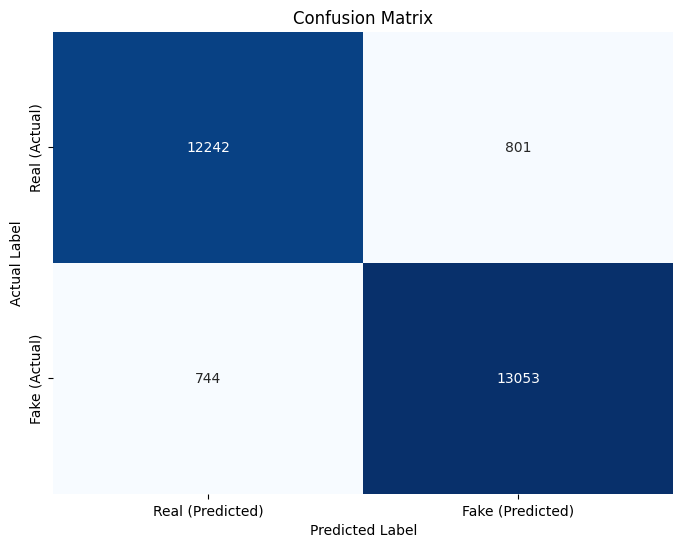

In [129]:
lr_classifier = LogisticRegression(max_iter=100, random_state=42, n_jobs=-1, solver="liblinear")

lr_results = train_eval_model_classifier(lr_classifier)
visualize_results(lr_results, "Logistic Regression")


Evaluation Metrics for:  Random Forest
              precision    recall  f1-score   support

        Real       0.94      0.92      0.93     13043
        Fake       0.92      0.94      0.93     13797

    accuracy                           0.93     26840
   macro avg       0.93      0.93      0.93     26840
weighted avg       0.93      0.93      0.93     26840

Accuracy:  0.9304023845007452
Precision:  0.924489360187887
Recall:  0.9415090237008045
F1 Score;  0.93292157426027


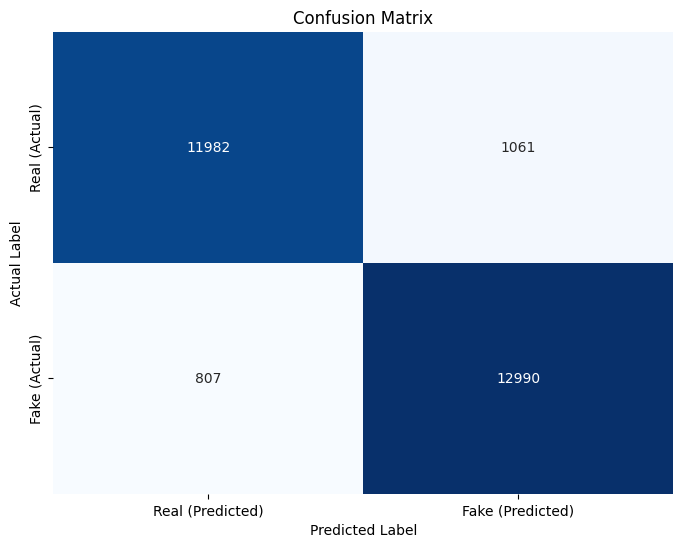

In [130]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

rf_results = train_eval_model_classifier(rf_classifier)
visualize_results(rf_results, "Random Forest")

Starting Grid Search...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END criterion=gini, max_depth=20, min_samples_split=2, n_estimators=100; total time=  10.9s
[CV] END criterion=gini, max_depth=20, min_samples_split=2, n_estimators=100; total time=  11.4s
[CV] END criterion=gini, max_depth=20, min_samples_split=5, n_estimators=100; total time=  10.3s
[CV] END criterion=gini, max_depth=20, min_samples_split=2, n_estimators=100; total time=  11.2s
[CV] END criterion=gini, max_depth=20, min_samples_split=5, n_estimators=100; total time=   9.6s
[CV] END criterion=gini, max_depth=20, min_samples_split=5, n_estimators=100; total time=   9.5s
[CV] END criterion=gini, max_depth=None, min_samples_split=5, n_estimators=100; total time= 2.3min
[CV] END criterion=gini, max_depth=None, min_samples_split=5, n_estimators=100; total time= 2.3min
[CV] END criterion=gini, max_depth=None, min_samples_split=5, n_estimators=100; total time= 2.3min
[CV] END criterion=gini, max_depth=No

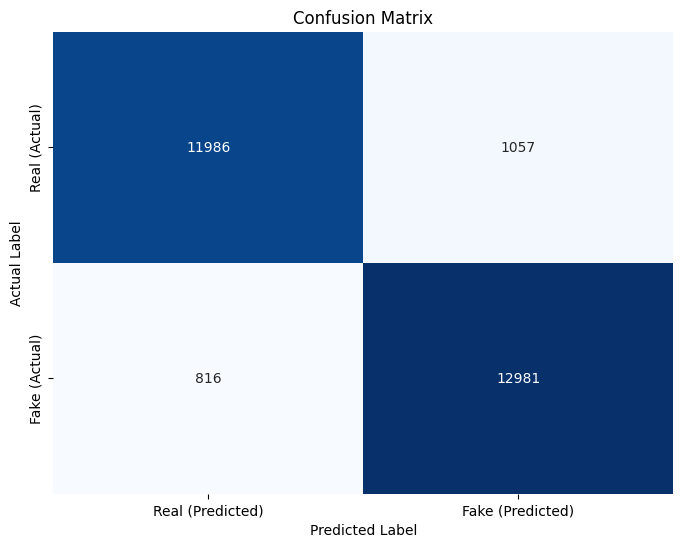

In [131]:
# Param grid for Random Forest
param_grid = {
    'n_estimators': [100],
    'max_depth': [None, 20],
    'min_samples_split': [2, 5],
    'criterion': ['gini', 'entropy']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,  # Use all available core
    verbose=2,
)


# Fit the grid search to the data
print("Starting Grid Search...")
grid_search.fit(X_train_combined, y_train)

# Best parameters and best score
print("Best Parameters Found:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# Evaluate the best model
best_rf = grid_search.best_estimator_
best_rf_results = best_rf.predict(X_test_combined)
visualize_results(best_rf_results, "Random Forest (Best Estimator)")